
# Supresvised Learning. Classification and Segmentation

---

Копейко Игорь Владимирович 281836

---



Topics: pytorch, data preparation, data augmentation, custom model, transfer learning, classification, segmentation

Main Tasks
1. Solve the road photo **classification** problem
  1. Prepare data and solve imbalanced dataset problem
  2. Implement and train a custom classifier
  3. Implement validation pipeline
  4. Add data augmentation and compare results
  5. Load pre-trained model and tune for road photos
2. Solve the road photo **segmentation** problem (the template for these tasks will be sent later)
  1. Prepare data
  2. Implement (by yourself) SegNet or U-net and train it
  3. Implement validation pipeline
  
Subtasks are specified in-place.

You can ask question about lab in the telegram [@vedyakov](https://t.me/vedyakov).

**Requirements**
1. You did the lab on your own.
2. All tasks and subtasks are completed. Conclusions are well-founded and valid.
3. The code is executable and the results are reproducible. If data is taken from your personal Google Drive, a link to the data should be provided.
4. The Colab notebook must contain the results of the code execution in the cell output.
5. The main structure of this Colab Notebook is preserved. You can add sections, write additional functions, and not significatly change the sections. If you remove any text and other things, make sure that all task results remain explicitly marked.
6. To pass the lab you should send the sharing link to your Colab Notebook via [Google Form](https://docs.google.com/forms/d/e/1FAIpQLSduYTm8gqbIYQDuRiWZwZSrC-NkWI_DxrU0xkyPteCiTboXvg/viewform).
If you want continue your work, make a copy of the notebook. The deadline date will be comparing with the last modification date of your notebook (you should not modify the notebook after you submit it).

**Deadlines for classification**
- Soft – 13.05 23:59:59
- Hard – 16.05 23:59:59

**Deadlines for segmentation**
- Soft – 21.05 23:59:59
- Hard – 24.05 23:59:59





 ## Enviroment setup

Import packages

In [2]:
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F
from torch import optim

from torchvision import models, transforms

import time
import math
import random

from torch.utils.data import TensorDataset, DataLoader, Dataset, WeightedRandomSampler
from sklearn.metrics import accuracy_score

import seaborn as sns
from matplotlib import colors, pyplot as plt
from matplotlib import rcParams
from IPython.display import clear_output

from tqdm import tqdm

%matplotlib inline
rcParams['figure.figsize'] = (15,4)
sns.set(style="darkgrid", font_scale=1.4)

Define the device variable to run notebook on gpu if it is available and cpu in the opposite case without any notebook modifications

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

GPU = torch.device('cuda:0')
CPU = torch.device('cpu')

Specify a seed to more reproducable results. Now the mentioned below random generators will produce the same random sequencies.

In [6]:
SEED = 42 # You can set any interger here

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True

Here some snippets to check GPU params

In [7]:
!nvidia-smi
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

Wed May  8 08:04:53 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

The snippet below can be used to check GPU memory allocation and clean it

In [8]:
import gc
torch.cuda.empty_cache()
gc.collect()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Tesla T4
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


## Dataset loading

### Way 1. By direct link

https://www.dropbox.com/s/j5j1kd4h55x4pmp/segmentation.zip?dl=0

In [9]:
!wget -c https://www.dropbox.com/s/j5j1kd4h55x4pmp/segmentation.zip?dl=0 -O segmentation.zip

--2024-05-08 08:05:00--  https://www.dropbox.com/s/j5j1kd4h55x4pmp/segmentation.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/j5j1kd4h55x4pmp/segmentation.zip [following]
--2024-05-08 08:05:00--  https://www.dropbox.com/s/raw/j5j1kd4h55x4pmp/segmentation.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucbdcbfaa21e19593cc3af69c15b.dl.dropboxusercontent.com/cd/0/inline/CScMmiiF7Vw6OGPmCKTlPnQIXhsxe9HjpPtHP6_8cGOlVwlPPPTDHzC7ZN-HG5Rhz6ATqh4A-n4Lha9LIZNahgm9s2tBIhO845zqP1nuoX-eEuRqAEnAEVO3wuzeqN3GM7k/file# [following]
--2024-05-08 08:05:01--  https://ucbdcbfaa21e19593cc3af69c15b.dl.dropboxusercontent.com/cd/0/inline/CScMmiiF7Vw6OGPmCKTlPnQIXhsxe9HjpPtHP6_8cGOlVwlPPPTDHzC7ZN-HG5Rhz6ATqh4A-n4Lha9LIZNahgm9s2tBIhO845zqP1nuoX

Then we should unzip

In [10]:
!unzip -q ./segmentation.zip

### Way 2. From personal Google drive
это второй способ, если первый не сработает

Add file to your personal google drive https://drive.google.com/file/d/1yqxfvTutEGOFMct5U_zVIP6e9v7R3AcL/view?usp=sharing or download from direct link https://www.dropbox.com/s/j5j1kd4h55x4pmp/segmentation.zip?dl=0 and upload to the personal google drive. In the example, the file in the University/MLR directory.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
!ls /content/gdrive/MyDrive/University/MLR

In [ ]:
!unzip -q /content/gdrive/MyDrive/University/MLR/segmentation.zip

## Data preparation

### Data checking

In [11]:
X = np.load('./x_train.npy')
Y = np.load('./y_train.npy')

print(X.shape)
print(Y.shape)
print(Y[0])

(3083, 256, 256, 3)
(3083, 256, 256, 1)
[[[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 ...

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]]


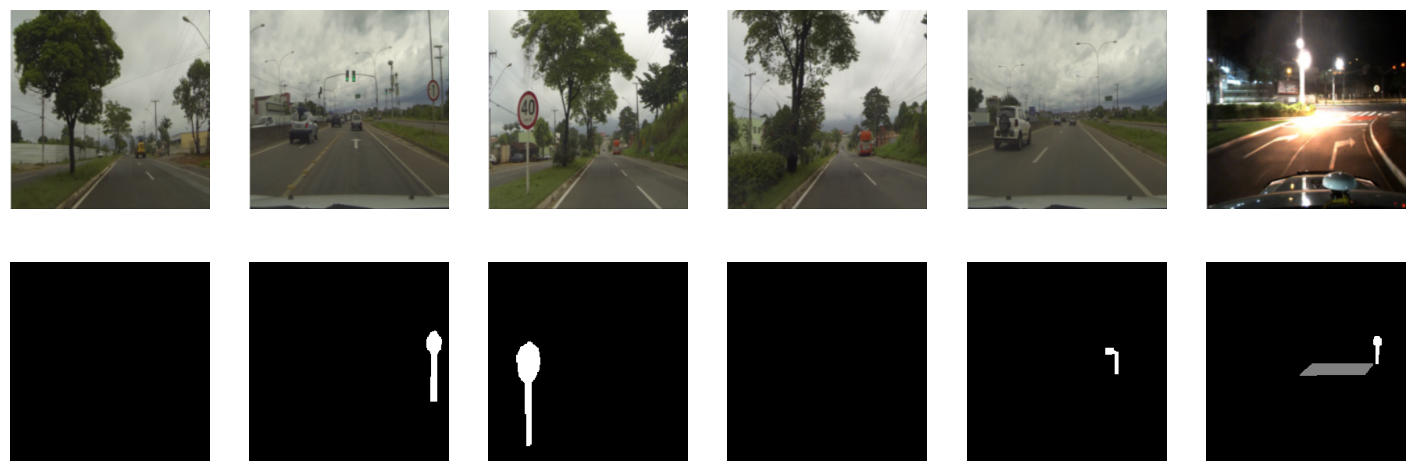

In [12]:
plt.figure(figsize=(18, 6))
for i in range(6):
    j = 100+10*i;
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[j])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[j].squeeze(), cmap='gray')
plt.show();

### Preparing target values for the classification task

Let us find all possible Y values in the dataset

In [13]:
unique, counts = np.unique(Y, return_counts=True)

result = np.column_stack((unique, counts))
print(result)

[[        0 192720674]
 [        1   8499283]
 [        2    827531]]


If number of non-black pixels is less than threshold, then we say that there is not a road sign on the photo

In [14]:
sum_by_image = np.sum(Y, (1, 2, 3))
print(sum_by_image.shape)

(3083,)


In [15]:
unique, counts = np.unique(sum_by_image, return_counts=True)
result = np.column_stack((unique, counts))
print (result)

[[    0   461]
 [    8     1]
 [   32     1]
 ...
 [29420     1]
 [29790     1]
 [33807     1]]


In [16]:
threshold = 32 #сделано. это типа порог. если сумма больше порога, то считаем что знак естьTODO: Define threshold for the number of non-black pixels
Y_c = np.array(sum_by_image > threshold, dtype='uint8')
print(Y_c.shape)

(3083,)


Now we have labels for classification task

In [17]:
print(Y_c[0:100])

[0 0 0 0 0 0 0 1 0 0 1 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 1 1 1 0 1 1 1 0 1 1 0 1 1 0 0 1 1 1 1 1 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 1 0 0]


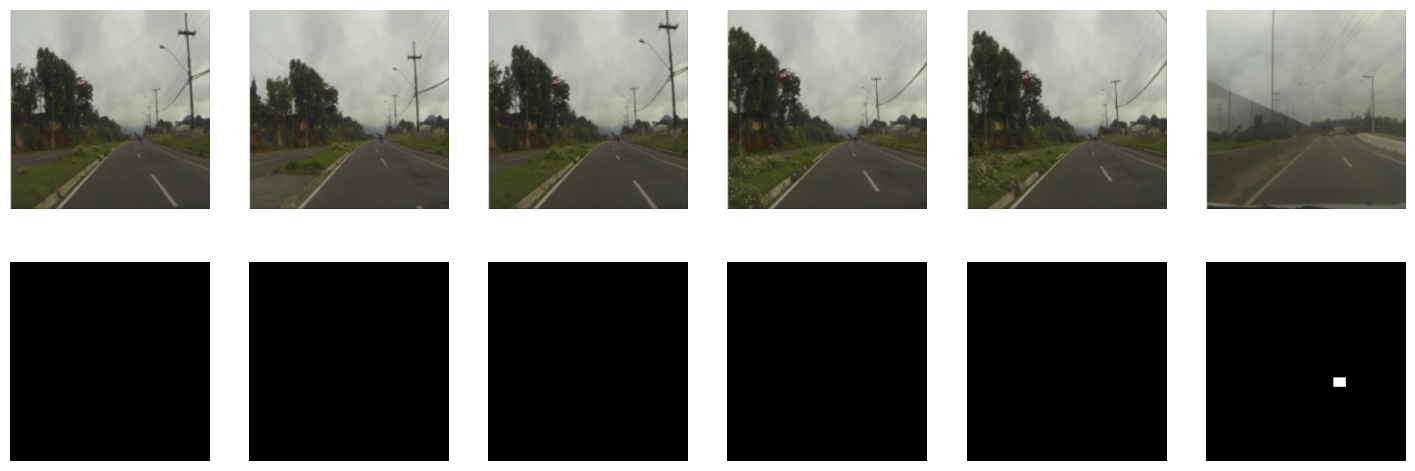

In [18]:
plt.figure(figsize=(18, 6))
for i in range(6):
    j = 2 + i;
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[j])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[j].squeeze(), cmap='gray')
plt.show();

### Data normalization

For pytorch, the channel should be the second dimension, not the last one.

In [19]:
X_r = np.transpose(X, axes=(0, 3, 1, 2))
Y_r = Y_c
print(X_r.shape, Y_r.shape)

(3083, 3, 256, 256) (3083,)


In [20]:
print(np.max(X_r),np.min(X_r))

255 0


Normalize data and convert to tensors нужно перевести в диапазон 0-1

Цифры тут посчитаны заранее. Это стандартные настройки для изображений


In [21]:
X_f = np.array(X_r / 255, dtype='float32')# сделано TODO: convert 0-255 values to 0-1
X_t = torch.FloatTensor(X_f)

for x in X_t:
  transforms.functional.normalize(x, (0.485, 0.456, 0.406), (0.229, 0.224, 0.225), inplace=True)

Y_t = torch.FloatTensor(Y_r)

Splitting dataset

Let us divide for traning, validation and test correspondingly.

In [22]:
ix = np.random.choice(len(X_t), len(X_t), False)
val_index = 2400     # сделаноTODO: set the index where dataset will be splitted between train and validation
test_index = 2700    # сделано TODO: set the index where dataset will be splitted between validation and test
tr, val, ts = np.split(ix, [val_index, test_index])

In [23]:
X_train_t = X_t[tr]
X_val_t = X_t[val]
X_test_t = X_t[ts]

Y_train_t = Y_t[tr]
Y_val_t = Y_t[val]
Y_test_t = Y_t[ts]

train_dataset = TensorDataset(X_train_t, Y_train_t)
val_dataset = TensorDataset(X_val_t, Y_val_t)
test_dataset = TensorDataset(X_test_t, Y_test_t)

In [24]:
unique, counts = np.unique(Y_train_t, return_counts=True)
result = np.column_stack((unique, counts))
print (result)

[[0.000e+00 3.640e+02]
 [1.000e+00 2.036e+03]]


Check converted and normalized data

In [25]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
      if hasattr(plt_ax, 'set_title'):
        plt_ax.set_title(title)
      if hasattr(plt_ax, 'title'):
        plt_ax.title(title)
    plt_ax.grid(False)

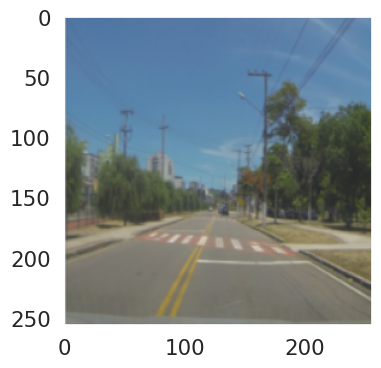

In [26]:
imshow(X_train_t[0])

### Classes balancing and creating dataloaders

Let's count how many pictures we have for each class.

Датасет несбалансирован, много фоток со знаками

In [27]:
unique, counts = np.unique(Y_r, return_counts=True)
result = np.column_stack((unique, counts))
print(result)

[[   0  463]
 [   1 2620]]


The dataset is not balanced, so let's define the weights for each class.

In order for the classes to be balanced in training, we calculate the weights and create a sampler.
For the validation and test, we will not use balancing.

Считаем уникальные значения. Будет картинки со знаками брать в пять раз меньше, потому что их слишком много

In [28]:
unique, counts = np.unique(Y_r[tr], return_counts=True)
w = np.min(counts)/counts
print(w)

[1.         0.17878193]


In [29]:
weights = [w[0] if x == 0 else w[1] for x in Y_r[tr]]
sampler = WeightedRandomSampler(weights, len(weights))    # сделано TODO: create WeightedRandomSampler instance, see https://pytorch.org/docs/stable/data.html#torch.utils.data.WeightedRandomSampler

print(Y_r[tr][50:100:5])
print(weights[50:100:5])

[1 1 1 1 1 1 0 1 0 1]
[0.1787819253438114, 0.1787819253438114, 0.1787819253438114, 0.1787819253438114, 0.1787819253438114, 0.1787819253438114, 1.0, 0.1787819253438114, 1.0, 0.1787819253438114]


In [30]:
train_dataloader = DataLoader(train_dataset, batch_size=128, sampler=sampler)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

Let's check that the classes are balanced now

In [31]:
YY_check = np.array([])

for _, y in train_dataloader:
  YY_check = np.hstack((YY_check, y.detach().numpy()))

unique, counts = np.unique(YY_check, return_counts=True)
result = np.column_stack((unique, counts))
print(result)

[[0.0e+00 1.2e+03]
 [1.0e+00 1.2e+03]]


Taking into account the imbalance of classes in the validation and test samples, we will use a special metric to evaluate the quality of training.

используется этот расчет, который использует несбалансированный датасет

In [32]:
from sklearn.metrics import balanced_accuracy_score, accuracy_score

## Custom classifier and training

**Pass requirement**: balanced_accuracy_score metric on the test part of the dataset is at least **0.95**.

Чтобы сдать задание, нужно точность 95. на этой архитектуре все нормально работает.

In [33]:
class SimpleCnn(nn.Module):

    def __init__(self, size, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(8)
        ) # => 128x8
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(16)
        ) # => 64x16
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(32)
        ) # => 32x32
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(64)
        ) # => 16x64

        fc_inputs = int((size/16)*(size/16)*64)

        self.out = nn.Sequential(
            nn.Flatten(),
            nn.Linear(fc_inputs, 96 * 5),
            nn.ReLU(),
            nn.BatchNorm1d(96 * 5),
            nn.Dropout(p=0.2),
            nn.Linear(96 * 5, 96 * 4),
            nn.ReLU(),
            nn.BatchNorm1d(96 * 4),
            nn.Dropout(p=0.1),
            # сделано TODO: Add last linear layer
            nn.Linear(96 * 4,n_classes)
        )


    def forward(self, x):
        # сделано TODO: pass x to sequentially to all conv layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)

        return logits.squeeze()

Let us define training function

In [35]:
def train(model, optimizer, loss_function, dataloader, max_epochs = 10):
  losses = np.zeros(max_epochs)

  model.train()
  for epoch in range(max_epochs):
      for it, (X_batch, y_batch) in enumerate(dataloader):
          X_batch = X_batch.to(device)
          y_batch = y_batch.to(device)

          optimizer.zero_grad()

          outp = model(X_batch)  # сделано TODO: predict y with model using X_batch

          loss = loss_function(outp.squeeze(), y_batch)
          losses[epoch] = losses[epoch] + loss.detach().flatten()[0]


          loss.backward()
          optimizer.step()
          # сделаноTODO: call back propagation and gradient calculation
          # сделано TODO: call weights update

          y_batch = y_batch.cpu()
          X_batch = X_batch.cpu()
          outp = outp.cpu()

      print(f"Epoch {epoch}: loss={losses[epoch]}")

  return losses

Now we can create model, define loss function and optimizer

In [36]:
simpleNN = SimpleCnn(256, 1).to(device)# сделано TODO: create model and move it to device
loss_function = nn.BCEWithLogitsLoss()# сделано TODO: create loss function
learning_rate = 0.005 # сделанр TODO: set learning rate
optimizer = torch.optim.Adam(simpleNN.parameters(), lr=learning_rate)

and train our model

In [ ]:
max_epochs = 20 # TODO: set max epochs number
losses = train(simpleNN, optimizer, loss_function, train_dataloader, max_epochs)

KeyboardInterrupt: 

In [39]:
def plot_losses(losses):
  plt.figure(figsize=(12, 8))
  plt.plot(range(len(losses)), losses)
  plt.xlabel("Iteration")
  plt.ylabel("Loss")
  plt.show()

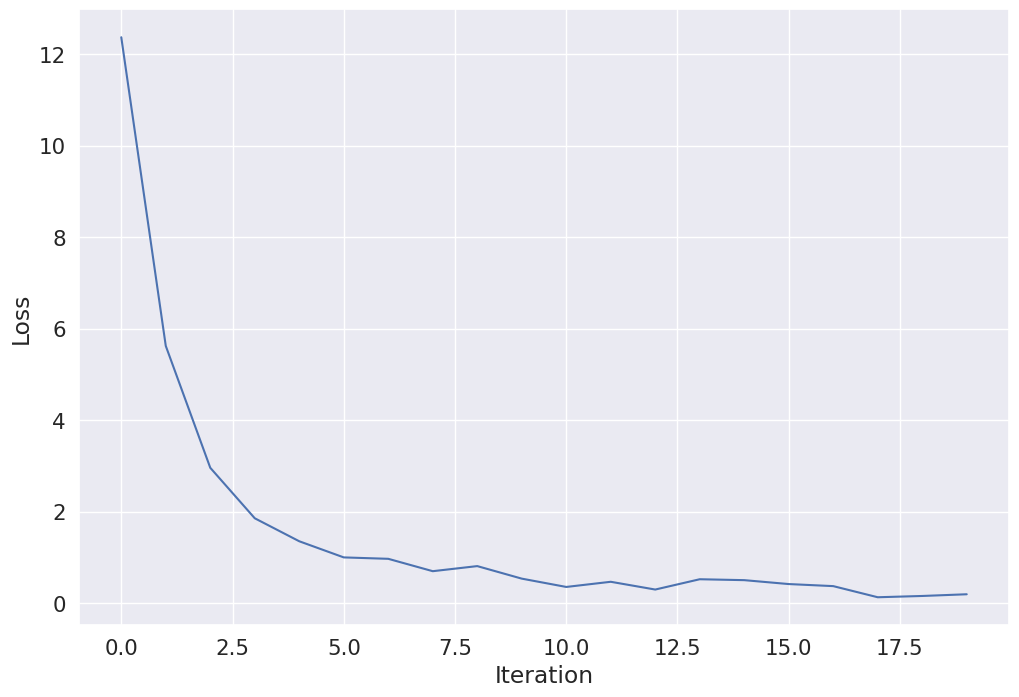

In [ ]:
plot_losses(losses)

We can additionally train the model with the lowel learning rate. However, the better idea is to use [schedulers](https://www.kaggle.com/code/isbhargav/guide-to-pytorch-learning-rate-scheduling), so we suggest to try it.

In [ ]:
# [OPTIONAL] TODO: try to use learning rate scheduler

## Model validation

In order to check overfitting we compate metric results on the train and validation datasets. If everything is ok, then we check on test dataset.

In [40]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    y_target = np.array([])
    for x_batch, y_batch in dataloader:
        y_target = np.hstack((y_target, y_batch.numpy().flatten()))
        x_batch = x_batch.to(device)
        lgts = model(x_batch)
        probs = torch.sigmoid(lgts)
        preds = (probs > 0.5).type(torch.long).cpu()
        predictions = np.hstack((predictions, preds.numpy().flatten()))
        x_batch = x_batch.cpu()
    model.train()
    # We return also target for the cases, when data is shuffled
    return predictions.flatten(), y_target

In [ ]:
Y_pred_train, Y_target_train = predict(train_dataloader, simpleNN)
print(balanced_accuracy_score(Y_target_train, Y_pred_train))
print(accuracy_score(Y_target_train, Y_pred_train))
# TODO: calculate accuracy with balanced_accuracy_score function

KeyboardInterrupt: 

In [ ]:
Y_pred_val, Y_target_val = predict(val_dataloader, simpleNN)
print(balanced_accuracy_score(Y_target_val, Y_pred_val))
print(accuracy_score(Y_target_val, Y_pred_val))
# TODO: calculate accuracy with balanced_accuracy_score function

0.9079999999999999

0.9666666666666667


In [ ]:
Y_test_pred, Y_test_target = predict(test_dataloader, simpleNN)
print(balanced_accuracy_score(Y_test_target, Y_test_pred))
print(accuracy_score(Y_test_target, Y_test_pred))
# TODO: calculate accuracy with balanced_accuracy_score function

0.953195649517292

0.97911227154047


**Вывод:**

Как видно, 20 эпох было предостаточно для обучения нашей нейронной сети. Более того, после 10 эпохи ошибка уже почти не уменьшается.

По результам проверки, нейросеть показала точность свыше 0.95 на тестовой выборке по функции balanced_accuracy_score и 0.97 по фунции accuracy_score. Поскольку датасет действительно не сбалансирован, ориентируемся на первый показатель.

Таким образом итоговый проходной результат для выполнения лабораторной работы достигнут, переходим к следующему пункту.



**Pass requirement:** balanced_accuracy_score metric on the val part of the dataset is at least 0.85. If accuracy is less than 0.85, then add the code below and fix it. If it is greater than 0.85 you can move to the next section.

In [ ]:
# TODO: try to train your model to achive balanced_accuracy_score > 0.85 (if it is less than 0.85)
# You can add as many text and code cells as needed

## Data Augmentation

In the common case the best way to increase size of the dataset is using on-fly data augmentation. In this case each time when we get item from the dataset transformation with random parameters is applied. However, the transformations must give you realistic images that are similar to the original images.

For the on-fly transformations we will create custom class dataset

In [41]:
class OurOwnDataset(Dataset):
    def __init__(self, data, labels, transforms=None):
        self.data = data
        self.labels = labels
        self.transforms = transforms

        print(f'Found {len(self.data)} items')

    def __getitem__(self, i):
        image = self.data[i]

        if self.transforms:
            image = self.transforms(image)

        label = self.labels[i]

        return image, label

    def __len__(self):
        return len(self.df)

In [43]:
from torchvision.transforms import Compose # TODO: add transforms import, see https://pytorch.org/vision/stable/transforms.html
from torchvision.transforms import v2

getitem_transforms = Compose([
    v2.RandomHorizontalFlip(),
    #v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    #v2.ColorJitter(brightness=.05, contrast=.1, saturation=.1, hue=.05),
    v2.RandomRotation(degrees=(-5, 5)),
    v2.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05), shear=5),
    v2.ToDtype(torch.float32, scale=True),
  # сделано TODO: add transforms
])

train_dataset_augmented = OurOwnDataset(X_train_t, Y_train_t, transforms=getitem_transforms)

Found 2400 items


Check how it is working

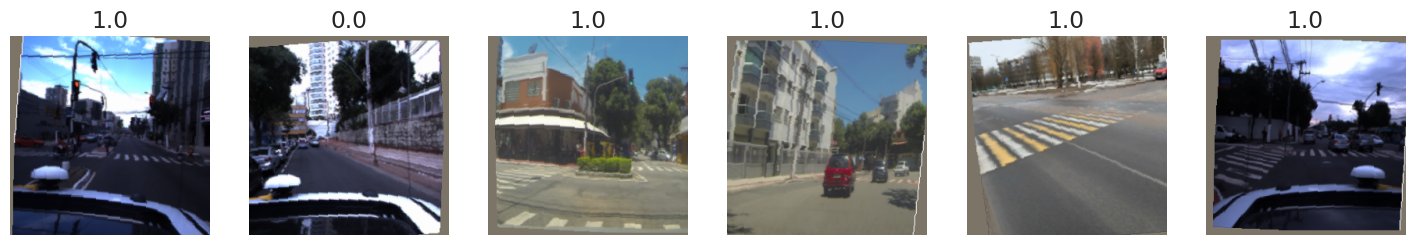

In [44]:
plt.figure(figsize=(18, 6))
for i in range(6):
    j = 100+10*i;
    image, label = train_dataset_augmented.__getitem__(j)

    plt.subplot(2, 6, i+1)
    plt.axis("off")

    imshow(image, title=f'{label}', plt_ax=plt)
plt.show();

In [45]:
train_dataloader_augmented = DataLoader(train_dataset_augmented, batch_size=64, sampler=sampler)

Now we can create new model and train it

In [46]:
model2 = SimpleCnn(256, 1).to(device)# сделано TODO: create a new model with SimpleCnn class and move it to device
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.005)

learning_rate2 = 0.005 # сделано TODO: set learning rate
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate2)

max_epochs2 = 40

In [ ]:
losses2 = train(model2, optimizer, loss_function, train_dataloader_augmented, max_epochs2) # сделано TODO: call train function and pass train_dataloader_augmented as dataloader

Epoch 0: loss=20.310218811035156

Epoch 1: loss=15.349032402038574

Epoch 2: loss=12.658419609069824

Epoch 3: loss=12.248453140258789

Epoch 4: loss=10.568946838378906

Epoch 5: loss=8.93789005279541

Epoch 6: loss=8.326096534729004

Epoch 7: loss=7.373215675354004

Epoch 8: loss=6.564228534698486

Epoch 9: loss=6.625062942504883

Epoch 10: loss=5.318624973297119

Epoch 11: loss=5.418154239654541

Epoch 12: loss=5.169893741607666

Epoch 13: loss=5.032649040222168

Epoch 14: loss=4.774831295013428

Epoch 15: loss=4.42006254196167

Epoch 16: loss=5.139777660369873

Epoch 17: loss=4.22829008102417

Epoch 18: loss=4.651578903198242

Epoch 19: loss=3.4864959716796875

Epoch 20: loss=4.495371341705322

Epoch 21: loss=3.662961006164551

Epoch 22: loss=3.710601568222046

Epoch 23: loss=3.4381392002105713

Epoch 24: loss=3.75030517578125

Epoch 25: loss=4.758120536804199

Epoch 26: loss=4.844018459320068

Epoch 27: loss=3.583557605743408

Epoch 28: loss=4.331984043121338

Epoch 29: loss=3.1675

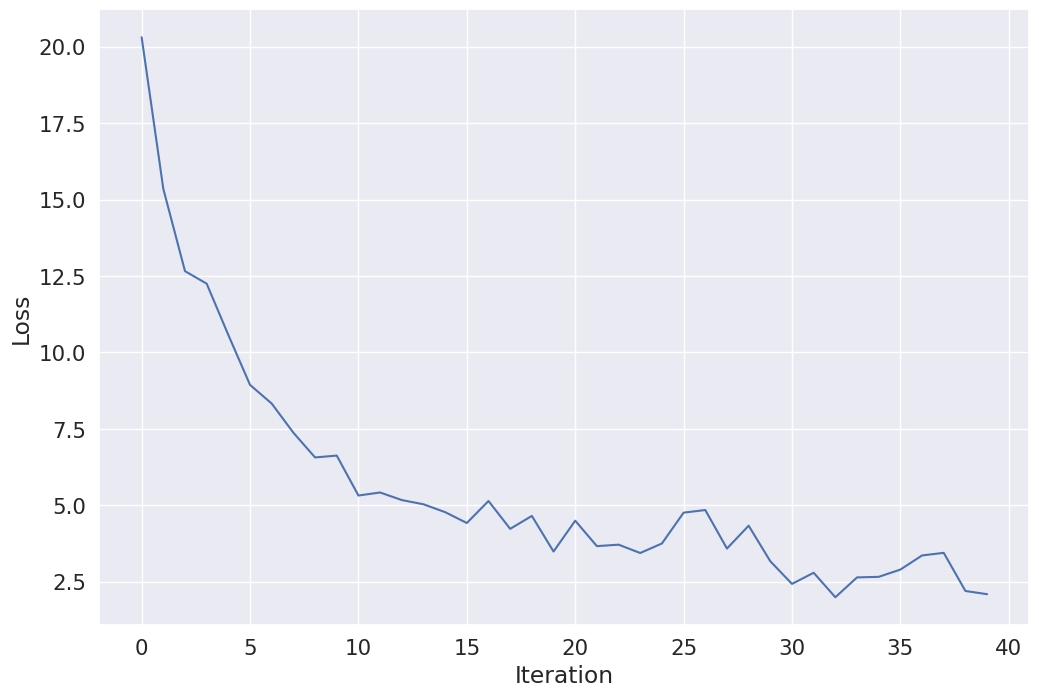

In [ ]:
plot_losses(losses2)

Check accuracy

In [ ]:
Y_train_pred2, Y_train_target2 = predict(train_dataloader_augmented, model2)
print(balanced_accuracy_score(Y_train_target2, Y_train_pred2))
print(accuracy_score(Y_train_target2, Y_train_pred2))
# TODO: calculate accuracy with balanced_accuracy_score function

0.984554339514931

0.9845833333333334


**Pass requirement**: balanced_accuracy_score metric on the val part of the dataset is at least 0.95.

In [ ]:
Y_pred_val2, Y_target_val2 = predict(val_dataloader, model2)
print(balanced_accuracy_score(Y_target_val2, Y_pred_val2))
print(accuracy_score(Y_target_val2, Y_pred_val2))
# TODO: calculate accuracy with balanced_accuracy_score function

0.952

0.96


**Вывод**

Для получения результата были использованы небольшие аффинные преобразования, поворот на 5 градусов и горизонтальное отражение. Также важным моментом стоит отметить, что был понижен размер batch чтобы преодолеть заветный порог в 0.95. От цветокорекции пришлось отказаться, потому что ее применение существенно ухудшало результат даже при самых малых изменениях.

## Transfer learning

The main idea is to load model and slightly tune it's parameters. The pre-trained models can be found in various libraries, for example in pytorch, or more specifically in [torchvision.models](https://pytorch.org/vision/stable/models.html#classification)

In [85]:
model3 = models.efficientnet_v2_s(pretrained=True)
# create model, for torchvision.models it will looks like: models.some_model_name(pretrained=True)
print(model3)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

First of all we must change the number of the outputs. For example, the models trained on IMAGENET have 1000 outputs, but we need only 1 output.

We can replace the whole classifier block (which is placed after convolution layers) or the last layer of the classifier.

In [86]:
# Disable gradient calculations for the pretrained model
# It will speed up the calculations and it is a way for freeze parameters values
for par in model3.parameters():
  par.requires_grad = False

model3.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1280, 96 * 5 ), #96 * 5
            nn.ReLU(),
            nn.BatchNorm1d(96 * 5),
            nn.Dropout(p=0.2),
            nn.Linear(96 * 5, 96 * 4),
            nn.ReLU(),
            nn.BatchNorm1d(96 * 4),
            nn.Dropout(p=0.1),
            # сделано TODO: Add last linear layer
            nn.Linear(96 * 4, 1)
        )
# сделано TODO: Define a new classifier block for the model3

In [87]:
model3 = model3.to(device)

Epoch 0: loss=15.690635681152344
Epoch 1: loss=11.061732292175293
Epoch 2: loss=9.969232559204102
Epoch 3: loss=9.08997917175293
Epoch 4: loss=8.758142471313477
Epoch 5: loss=7.6405487060546875
Epoch 6: loss=8.33997917175293
Epoch 7: loss=7.782904624938965
Epoch 8: loss=7.242316722869873
Epoch 9: loss=6.632120132446289
Epoch 10: loss=6.472644329071045
Epoch 11: loss=6.690011024475098
Epoch 12: loss=6.333737373352051
Epoch 13: loss=5.3642258644104
Epoch 14: loss=6.4808030128479
Epoch 15: loss=6.257550239562988
Epoch 16: loss=6.109013080596924
Epoch 17: loss=5.823336124420166
Epoch 18: loss=6.12074613571167
Epoch 19: loss=5.117042541503906


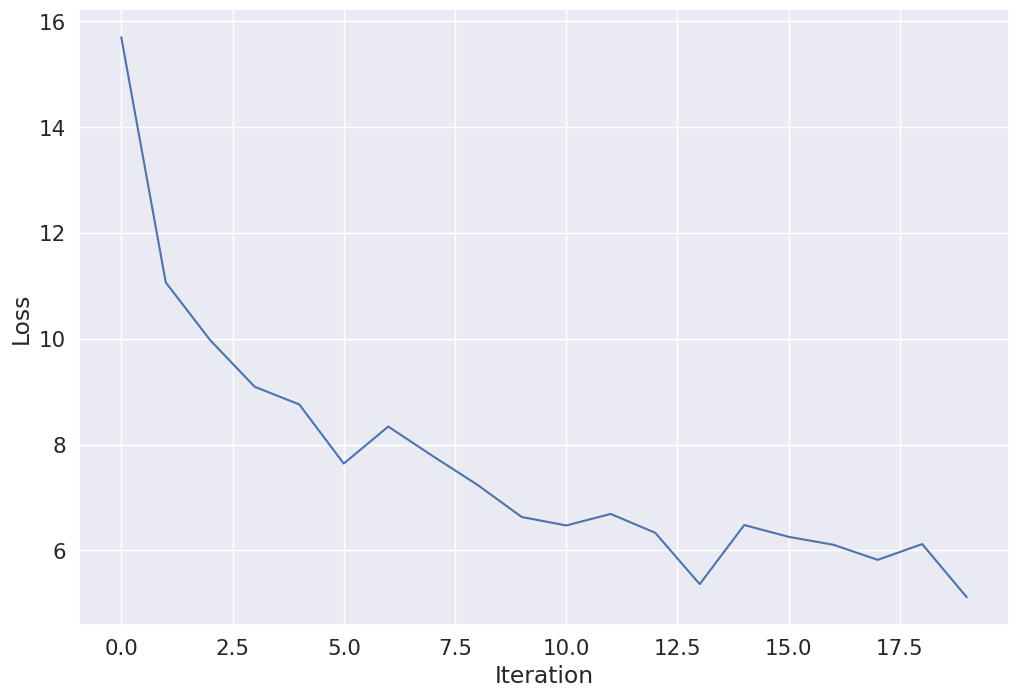

In [88]:
# You can tune only classifier parameters by passing only that params to the optimizer
max_epochs3 = 20
learning_rate3 = 0.005

optimizer3 = torch.optim.Adam(model3.classifier.parameters(), lr=learning_rate3) # сделано TODO: create optimizer and pass to it onl ymodel3.classifier parameters
losses3 = train(model3, optimizer3, loss_function, train_dataloader_augmented, max_epochs3) # TODO: call train function for model3
plot_losses(losses3)

Epoch 0: loss=6.697204113006592
Epoch 1: loss=5.38422966003418
Epoch 2: loss=5.958216667175293
Epoch 3: loss=5.847825050354004
Epoch 4: loss=6.459647178649902
Epoch 5: loss=4.814260005950928
Epoch 6: loss=5.444816589355469
Epoch 7: loss=5.192078113555908
Epoch 8: loss=4.531095027923584
Epoch 9: loss=5.464319229125977


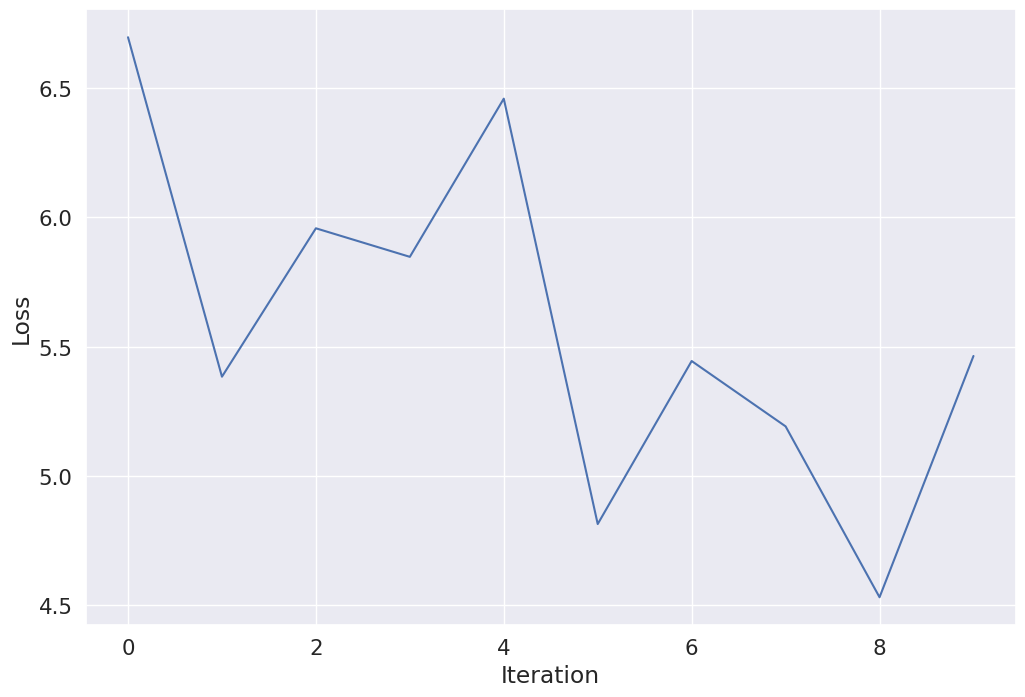

In [90]:
max_epochs3 = 10
learning_rate3 = 0.005

optimizer3 = torch.optim.Adam(model3.classifier.parameters(), lr=learning_rate3) # сделано TODO: create optimizer and pass to it onl ymodel3.classifier parameters
losses3 = train(model3, optimizer3, loss_function, train_dataloader_augmented, max_epochs3) # TODO: call train function for model3
plot_losses(losses3)

Epoch 0: loss=3.707049608230591
Epoch 1: loss=4.853779315948486
Epoch 2: loss=4.204500675201416
Epoch 3: loss=4.331623554229736
Epoch 4: loss=4.431478977203369


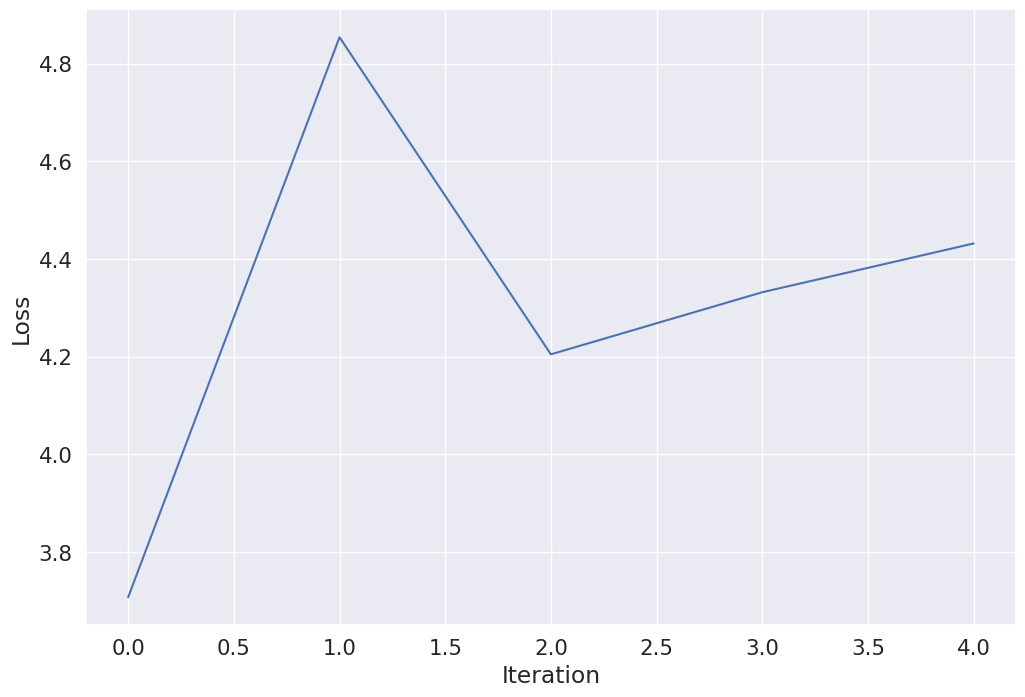

In [92]:
max_epochs3 = 5
learning_rate3 = 0.002

optimizer3 = torch.optim.Adam(model3.classifier.parameters(), lr=learning_rate3) # сделано TODO: create optimizer and pass to it onl ymodel3.classifier parameters
losses3 = train(model3, optimizer3, loss_function, train_dataloader_augmented, max_epochs3) # TODO: call train function for model3
plot_losses(losses3)

In [93]:
Y_pred_train3, Y_train_target3 = predict(train_dataloader, model3)
print(balanced_accuracy_score(Y_train_target3, Y_pred_train3))
print(accuracy_score(Y_train_target3, Y_pred_train3))
# TODO: calculate accuracy with balanced_accuracy_score function

0.9761572736566069
0.97625


**Pass requirement**: balanced_accuracy_score metric on the val part of the dataset is at least **0.95**.

In [94]:
Y_pred_val3, Y_target_val3 = predict(val_dataloader, model3)
print(balanced_accuracy_score(Y_target_val3, Y_pred_val3))
print(accuracy_score(Y_target_val3, Y_pred_val3))
# TODO: calculate accuracy with balanced_accuracy_score function

0.952
0.96


**Вывод**

Касательно использования готовой сети стоит отметить большое влияние случайности на результат. Несколько запусков одной и той же сети приводили к разным результатам. Так в один запуск я получал 0.92, в другой 0.91, а в третий 0.95. и все это на одних и тех же настройках, правда это было выполнено на другом компьютере и с сетью efficientnet_b1.

В данном же случае приходилось немного дообучать сеть и менять шаг, но результат успешно достигнут.